In [1]:
from load_high_resolution_digits import *
from edge_detection import *

images, info = load_dataset('dataset')
y = create_targets(info)
x = images

print(x.shape)
shape = images[0].shape
print(shape)

Loaded 13580 images and 13580 writer information entries.
(13580, 500, 500)
(500, 500)


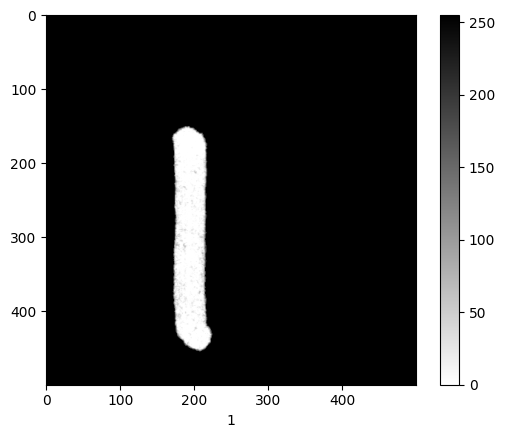

In [2]:
visualize_one_image(x[0], y[0], shape)

[  0 255]


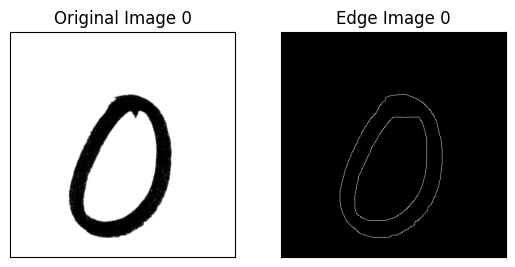

[  0 255]


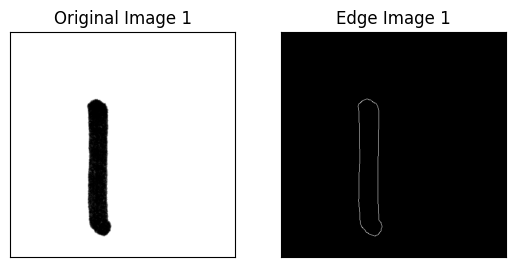

[  0 255]


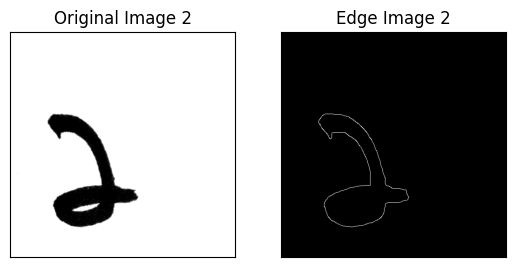

[  0 255]


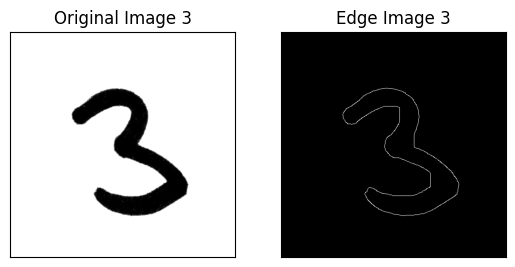

[  0 255]


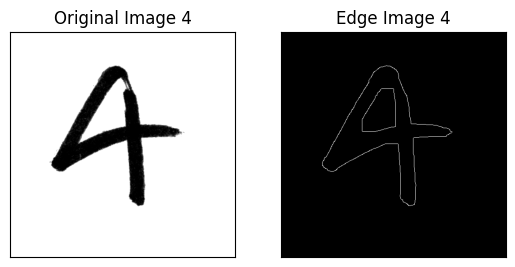

[  0 255]


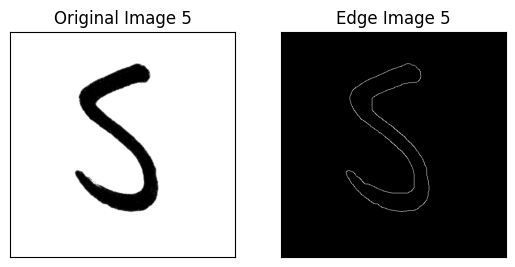

[  0 255]


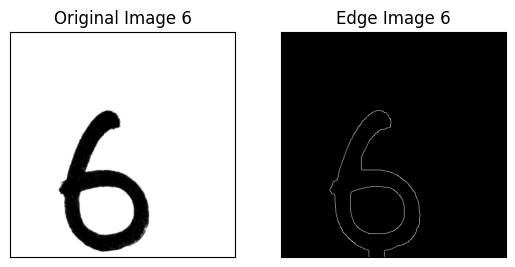

[  0 255]


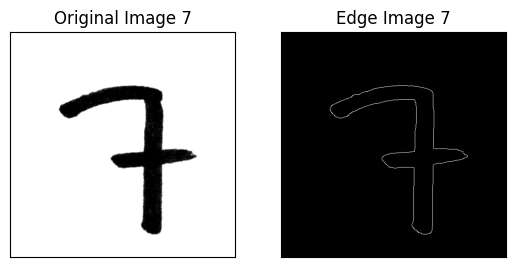

[  0 255]


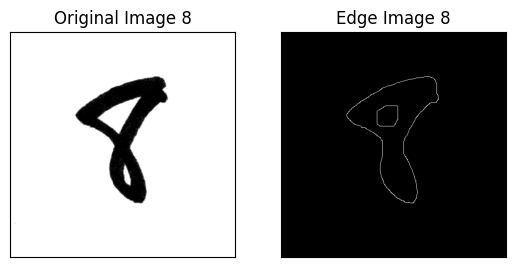

[  0 255]


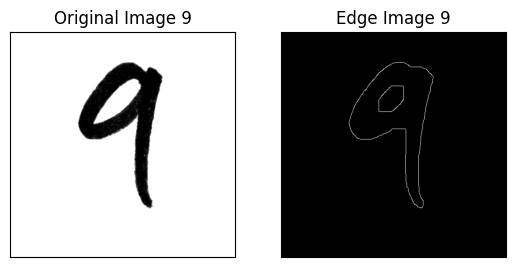

In [3]:
def display_for_each_digit(x, y):
    labels = np.unique(y)
    for label in labels:
        ind = np.where(y == label)[0][0]
        edges = extract_edges(x[ind], shape)
        print(np.unique(edges))
        visualize_img_edges(x[ind], y[ind], edges, shape)

display_for_each_digit(x, y)

### My kernels

In [4]:
def create_linear_kernel(size):
    kernels = []
    #Create horizontal & vertical kernels
    for i in range(size):
        kernel = np.zeros((size, size))
        kernel[i, :] = 1 # Horizontal
        verti = (kernel.T) # Vertical
        kernels.append(kernel)
        kernels.append(verti)
    #Create diagonal offseted kernels
    for i in range(-(size-2), (size-1)):
        kernel = np.eye(size, k=i)
        flipeped = np.fliplr(kernel)
        kernels.append(kernel)
        kernels.append(flipeped)

def create_linear_kernel(size):
    kernels = []
    #Create horizontal & vertical kernels
    for i in range(size):
        kernel = np.zeros((size, size))
        kernel[i, :] = 1 # Horizontal
        verti = (kernel.T) # Vertical
        kernels.append(kernel)
        kernels.append(verti)
    #Create diagonal offseted kernels
    for i in range(-(size-2), (size-1)):
        kernel = np.eye(size, k=i)
        flipeped = np.fliplr(kernel)
        kernels.append(kernel)
        kernels.append(flipeped)

    # Map 0 to -1
    kernels = [np.where(kernel == 0, -1, kernel) for kernel in kernels]

    # Sort by number of ones in kernel
    kernels = sorted(kernels, key=lambda x: np.sum(x == 1))
    
    return kernels

### ChatGPT kernels

In [87]:
import numpy as np

def generate_edge_detection_kernels(resolution=(500, 500), kernel_size=3):
    """
    Generates a set of edge detection kernels of variable size.
    
    :param resolution: The resolution of the image (default is 500x500).
    :param kernel_size: The size of the kernels (default is 3x3).
    :return: A dictionary containing edge detection kernels.
    """
    
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd.")
    
    # Initialize kernels list
    kernels = []
    
    # Generate the horizontal and vertical edge detection kernels
    def sobel_kernel(size, orientation='horizontal'):
        # Generate a basic Sobel-like kernel for horizontal or vertical direction
        k = np.zeros((size, size))
        center = size // 2
        
        if orientation == 'horizontal':
            for i in range(size):
                k[i, :] = (i - center)
        elif orientation == 'vertical':
            for i in range(size):
                k[:, i] = (i - center)
        return k
    
    def prewitt_kernel(size, orientation='horizontal'):
        # Generate a basic Prewitt-like kernel for horizontal or vertical direction
        k = np.zeros((size, size))
        center = size // 2
        
        if orientation == 'horizontal':
            k[center, :] = np.arange(-center, center + 1)
        elif orientation == 'vertical':
            k[:, center] = np.arange(-center, center + 1)
        return k

    def diagonal_kernel(size, angle=45):
        # Generate a diagonal kernel
        k = np.zeros((size, size))
        center = size // 2
        if angle == 45:
            for i in range(size):
                for j in range(size):
                    if i == j:
                        k[i, j] = (i - center)
        elif angle == 135:
            for i in range(size):
                for j in range(size):
                    if i + j == size - 1:
                        k[i, j] = (i - center)
        return k

    # Create Sobel kernels
    kernels.append(sobel_kernel(kernel_size, orientation='horizontal'))
    kernels.append(sobel_kernel(kernel_size, orientation='vertical'))

    # Create Prewitt kernels
    kernels.append(prewitt_kernel(kernel_size, orientation='horizontal'))
    kernels.append(prewitt_kernel(kernel_size, orientation='vertical'))


    # Create diagonal kernels
    for angle in [0, 180, 10]:
        if angle != 0 and angle != 90 and angle != 180:
            kernels.append(diagonal_kernel(kernel_size, angle=angle))
    
    #kernels.append(diagonal_kernel(kernel_size, angle=45))
    #kernels.append(diagonal_kernel(kernel_size, angle=135))

    return kernels

kernels = generate_edge_detection_kernels(kernel_size=3)
kernels[0]

array([[-1., -1., -1.],
       [ 0.,  0.,  0.],
       [ 1.,  1.,  1.]])

In [116]:
def generate_curved_edge_kernels(image_shape=(500, 500), kernel_size=3, angle_step=10, radius_step=5):

    def generate_curved_edge_kernel(kernel_size=7, angle_range=(0, 90), radius=None):
        """
        Generates a curved edge detection kernel that highlights intensity transitions along a curved path.
        
        :param kernel_size: The size of the kernel (must be odd).
        :param angle_range: The angular range (in degrees) of the curved edge to detect. 
                            Default is (0, 90) for a quarter-circle.
        :param radius: The radius of the curved pattern. Default is half the kernel size.
        :return: A curved edge detection kernel of the given size.
        """
        
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd.")
        
        # Initialize the kernel
        kernel = np.full((kernel_size, kernel_size), -1.0)  # Initialize with -1
        
        # Find the center of the kernel
        center = kernel_size // 2
        
        # Convert angle range from degrees to radians
        angle_min = np.radians(angle_range[0])
        angle_max = np.radians(angle_range[1])
        
        # Compute the radius for the curved pattern (equal to center distance)
        if radius is None:
            radius = center
        
        # Create a positive and negative pattern along the curved path
        for i in range(kernel_size):
            for j in range(kernel_size):
                # Calculate the angle of the current point relative to the center
                dx = j - center
                dy = i - center
                distance = np.sqrt(dx**2 + dy**2)
                
                # Calculate the angle in radians of the current point
                if dx == 0 and dy == 0:
                    angle = 0  # At the center
                else:
                    angle = np.arctan2(dy, dx)  # Calculate angle from the center
                
                # Check if the point is within the radius and angle range
                if distance <= radius and angle_min <= angle <= angle_max:
                    # Assign positive values on one side of the curve and negative on the other side
                    if distance > radius / 2:
                        kernel[i, j] = -1  # Outside part of curve
                    else:
                        kernel[i, j] = 1  # Inside part of curve
                elif i >= 2 and j >= 2:
                    if i == 2 or j == 2:
                        kernel[i, j] = 0
                    else:
                        kernel[i, j] = 1
        
        return kernel

    # List to store all generated kernels
    kernels = []
    
    # Define the maximum radius based on image size and kernel size
    max_radius = min(image_shape) // 4
    
    # Sweep through radii and angles to generate multiple kernels
    radii = range(max_radius, 50, -radius_step)
    
    # Generate quarter-circle and half-circle kernels
    for angle in range(0, 360, angle_step):
        for radius in radii:
            # Generate quarter-circle kernels (e.g., 90-degree arcs)
            quarter_kernel = generate_curved_edge_kernel(kernel_size=kernel_size, angle_range=(angle, angle + 90), radius=radius)
            kernels.append(quarter_kernel)
            
            # Generate half-circle kernels (e.g., 180-degree arcs)
            half_kernel = generate_curved_edge_kernel(kernel_size=kernel_size, angle_range=(angle, angle + 180), radius=radius)
            kernels.append(half_kernel)

    return kernels

# Example usage: Generate kernels for detecting curved lines in a 500x500 image
curved_kernels = generate_curved_edge_kernels(image_shape=(500, 500), kernel_size=7, angle_step=30, radius_step=10)
curved_kernels[0]

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1.,  0.,  1.,  1.,  1.,  1.],
       [-1., -1.,  0.,  1.,  1.,  1.,  1.],
       [-1., -1.,  0.,  1.,  1.,  1.,  1.],
       [-1., -1.,  0.,  1.,  1.,  1.,  1.]])

In [96]:
def create_linear_kernels(sizes, linear_kernel_function):
    kernels = []
    for size in sizes:
        kernels += linear_kernel_function(size)
    return kernels

def create_curved_kernels(img_shape, sizes, curved_kernel_function):
    kernels = []
    for size in sizes:
        kernels += curved_kernel_function(img_shape, size)
    return kernels

def all_kernels(linear_sizes, curved_sizes, linear_kernel_function, circular_kernel_function):
    return create_curved_kernels(curved_sizes, circular_kernel_function) + create_linear_kernels(linear_sizes, linear_kernel_function)

In [40]:
def convolve(image, start_row, start_col, kernel):
    submatrix = image[start_row:start_row + kernel.shape[0], start_col:start_col + kernel.shape[1]] 
    return submatrix * kernel

def calculate_conv_value(image, start_row, start_col, kernel):
    return np.sum(convolve(image, start_row, start_col, kernel))

def define_thresholds(ratio, kernels):
    thresholds = []
    white_digit = 255
    for kernel in kernels:
        count_1 = np.sum(kernel == 1)
        thresholds.append(ratio * (count_1 * white_digit))
    return thresholds

# firsts = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
# print(x[0].shape)
# convolve(x[0], firsts, create_linear_kernel(3)[0])

In [41]:
# Create a list full of False values of shape image
def create_img_map(image):
    return np.zeros(image.shape, dtype=bool)

# Update the image map with True for specified indices
def update_img_map(img_map, indices):
    img_map[indices] = True
    return img_map

# Check if any pixel is a convolution pixel
def is_conv_pixels(img_map, indices):
    return np.any(img_map[indices])

# Create a grid of convolution pixels and return the list of indices
# Using image size and kernel size, slice the whole image into a grid of size kernel
# Where indices overlaps, because kernel will move by 1 pixel, we will have overlapping indices
# Example for first entry of indices for 3x3 kernel
# [[0, 1, 2],
#  [0, 1, 2],
#  [0, 1, 2]]
# Secon entry of indices for 3x3 kernel
# [[1, 2, 3],
#  [1, 2, 3],
#  [1, 2, 3]]

def create_conv_grid(image, kernel):
    # Precompute the list of pairs (start_row, start_col) for each convolution position.
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    indices = []
    for i in range(image_height - kernel_height + 1):
        for j in range(image_width - kernel_width + 1):
            indices.append((i, j))
    
    return indices

def convolve_image_with_kernel(image, img_map, kernel, threshold,
                               above_threshold_indices, 
                               above_threshold_kernels):
    #Ceate a grid of convolution pixels
    conv_grid = create_conv_grid(image, kernel)
    for start_row, start_col in conv_grid:
        indices = (slice(start_row, start_row + kernel.shape[0]), slice(start_col, start_col + kernel.shape[1]))
        if not is_conv_pixels(img_map, indices):
            conv_value = calculate_conv_value(image, start_row, start_col, kernel)
            if conv_value > threshold:
                img_map = update_img_map(img_map, indices)
                above_threshold_indices.append(indices)
                above_threshold_kernels.append(kernel)
    return img_map, above_threshold_indices, above_threshold_kernels

def calculate_unique_edge_percentage(img_map, image):
    """
    Calculate the percentage of unique edge pixels detected.
    
    Args:
        img_map (np.ndarray): Boolean array indicating where edges are detected.
        image (np.ndarray): The original image.
    
    Returns:
        float: The percentage of unique edge pixels detected.
    """
    # Get the indices where img_map is True
    edge_indices = np.argwhere(img_map)
    
    # Use a set to keep track of unique indices
    unique_indices = set(tuple(index) for index in edge_indices)
    
    # Calculate the percentage of unique edge pixels detected
    unique_edge_count = len(unique_indices)
    total_pixels = image.size
    percentage = (unique_edge_count / total_pixels) * 100
    
    return percentage

def convolve_image_with_kernels(image, kernels, thresholds):
    img_map = create_img_map(image)
    
    above_threshold_indices = []
    above_threshold_kernels = []

    for i in range(len(kernels)):
        kernel = kernels[i]
        threshold = thresholds[i]
        img_map, above_threshold_indices, above_threshold_kernels = convolve_image_with_kernel(image, img_map, kernel, threshold,
                                                                                              above_threshold_indices,
                                                                                              above_threshold_kernels)
        if i % 10 == 0:
            print(f'Kernel {i} out of {len(kernels)}')
            print(f'Number of above threshold kernels: {len(above_threshold_kernels)}')
            
            # Calculate and print the percentage of unique edge pixels detected
            percentage = calculate_unique_edge_percentage(img_map, image)
            print(f'Percentage of unique edge pixels detected: {percentage:.2f} %')
    return img_map, above_threshold_indices, above_threshold_kernels


#firsts = create_conv_grid(x[0], create_linear_kernel(3)[0])[0]
#print(firsts)
#convolve_image_with_kernel(x[0], create_img_map(x[0]), create_linear_kernel(3)[0], 0.5, [], [])

In [117]:
import gc
gc.collect()

label = y[0]
print(label)
image = x[0]
edges = extract_edges(image, shape)
print(edges.shape)

curved_kernel_sizes = [25]#5[51, 21, 11]
linear_kernel_sizes = [21, 5]

kernels = create_curved_kernels( image.shape, curved_kernel_sizes, generate_curved_edge_kernels)
#kernels = create_linear_kernels(kernel_sizes, generate_edge_detection_kernels)
#kernels = all_kernels(linear_kernel_sizes, curved_kernel_sizes, generate_edge_detection_kernels, generate_curved_edge_kernels)
thresholds = define_thresholds(0.9, kernels)
img_map, above_threshold_indices, above_threshold_kernels = convolve_image_with_kernels(edges, kernels, thresholds)


1
(500, 500)
Kernel 0 out of 10
Number of above threshold kernels: 0
Percentage of unique edge pixels detected: 0.00 %


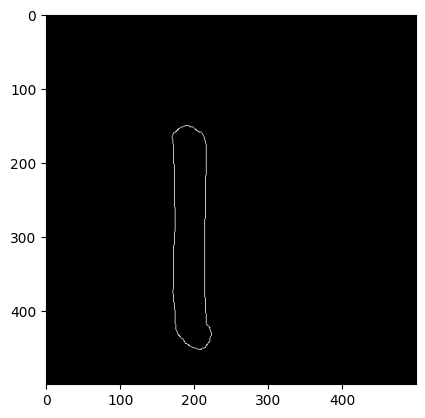

In [118]:
def slices_to_indices(slices):
    """
    Convert a tuple of slice objects into a list of indices.
    
    Args:
        image_shape (tuple): The shape of the image (height, width).
        slices (tuple): A tuple of slice objects (row_slice, col_slice).
    
    Returns:
        list of tuple: List of indices (row, col) for the specified slices.
    """
    row_slice, col_slice = slices
    row_indices, col_indices = np.mgrid[row_slice, col_slice]
    indices = [(r, c) for r, c in zip(row_indices.flatten(), col_indices.flatten())]
    return indices

def visualize_convolution(image, img_map, above_threshold_indices, above_threshold_kernels):
    plt.figure()
    plt.imshow(image, cmap='gray')
    for i in range(len(above_threshold_indices)):
        indices = above_threshold_indices[i]
        indices = slices_to_indices(indices)
        kernel = above_threshold_kernels[i]

        #draw matched indices
        # for index in indices:
        #    plt.text(index[1], index[0], '.', color='yellow')
        
        #draw fitted kernels
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                if kernel[i, j] == 1:
                    plt.text(indices[0][1] + j, indices[0][0] + i, '.', color='blue')
        
    # # Draw horizontal lines
    # for i in range(0, image.shape[0], 31):
    #     plt.axhline(i, color='red')
    
    # # Draw vertical lines
    # for j in range(0, image.shape[1], 31):
    #     plt.axvline(j, color='red')
    # plt.show()

#visualize_convolution(image, img_map, above_threshold_indices, above_threshold_kernels)
visualize_convolution(edges, img_map, above_threshold_indices, above_threshold_kernels)